|feature|dimension|memo|
|:-:|:-:|:-:|
|adx|-|DI = price_diff / price_diff|
|adxr|-|ma(adx)|
|rsi|-||
|aroon_down/up|-|days after new high|
|aroon_osc|-|aroon_up - aroon_down|
|cci|roc|price_diff / ma(price_diff)|
|cmo|-|2 * rsi - 100. essentially same as rsi|
|dx|-||
|mfi|-|money flow = dollar. money flow ratio = dollar ver of volume ratio. (ftx's volume is dollar. so, it is meaningless to use mfi directly)|
|trix|roc||
|atr|price_diff||
|natr|roc||
|obv_rsi|-|rsi(obv)|
|ad_rsi|-|rsi(ad)|
|macdsignal|price_diff||
|stoch|-||
|stochf|-||
|stochrsi|-||
|ultosc|-|price_diff / price_diff|

- roc: rate of price change

good features

- dimension less
- bounded
- distribution is independent from symbol and time (price, std, price unit, volume)

feature rule

- dimension less
- bounded [-1, 1], [0, 1]



In [1]:
import sys
sys.path.append('..') # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib
import seaborn as sns

import src
from src.ml_utils import (
    fetch_ohlcv,
    visualize_result,
    normalize_position,
    calc_position_cv,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
cloudpickle.register_pickle_by_value(src) # for model portability

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [39]:
# symbols = 'BTC,ETH'.split(',')
symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
df = fetch_ohlcv(symbols=symbols, with_target=True, price_type=None)
df.to_pickle('/tmp/df_price_type_none.pkl')
display(df)

op            hi            lo  \
timestamp                 symbol                                             
2019-07-20 00:00:00+00:00 BNB        29.074200     29.251700     28.981150   
                          BTC     10532.400561  10596.176732  10451.465293   
                          ETH       221.191514    224.079639    221.015166   
                          XRP         0.319763      0.323658      0.319140   
2019-07-20 01:00:00+00:00 BNB        29.102050     30.051750     28.937300   
...                                        ...           ...           ...   
2022-09-02 08:00:00+00:00 ETH      1594.401429   1596.874286   1585.030000   
                          LINK        6.882598      6.912045      6.853060   
                          MATIC       0.881401      0.890773      0.880405   
                          SOL        31.624165     31.658390     31.415591   
                          XRP         0.331690      0.331690      0.330483   

                                            cl        execution_start_at  \
timestamp                 symbol                                           
2019-07-20 00:00:00+00:00 BNB        29.102300 2019-07-20 01:00:00+00:00   
                          BTC     10466.256172 2019-07-20 01:00:00+00:00   
                          ETH       221.450416 2019-07-20 01:00:00+00:00   
                          XRP         0.319678 2019-07-20 01:00:00+00:00   
2019-07-20 01:00:00+00:00 BNB        30.036500 2019-07-20 02:00:00+00:00   
...                                        ...                       ...   
2022-09-02 08:00:00+00:00 ETH      1590.434286 2022-09-02 09:00:00+00:00   
                          LINK        6.873536 2022-09-02 09:00:00+00:00   
                          MATIC       0.890107 2022-09-02 09:00:00+00:00   
                          SOL        31.562069 2022-09-02 09:00:00+00:00   
                          XRP         0.330670 2022-09-02 09:00:00+00:00   

                                       ret  
timestamp                 symbol            
2019-07-20 00:00:00+00:00 BNB     0.063542  
                          BTC     0.034167  
                          ETH     0.034369  
                          XRP     0.043545  
2019-07-20 01:00:00+00:00 BNB     0.016383  
...                                    ...  
2022-09-02 08:00:00+00:00 ETH          NaN  
                          LINK         NaN  
                          MATIC        NaN  
                          SOL          NaN  
                          XRP          NaN  

[245753 rows x 6 columns]

In [2]:
import numba

df = pd.read_pickle('/tmp/df_price_type_none.pkl')
# df = pd.read_pickle('/tmp/df_horizon96_price_type_none.pkl')

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return v.rolling(timeperiod, 1).mean() / (1e-37 + v.abs().rolling(timeperiod, 1).mean())

def calc_features(df):
    dfs = []
    for symbol, df_symbol in df.groupby('symbol'):
        dfs.append(calc_features_single(df_symbol))
    df = pd.concat(dfs).sort_index()

    df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
    df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(24 * 30, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)

    ret_mean = df.groupby('timestamp')['ret'].transform('mean')
    dfs = [
        df,
        (unbiased_rank(df.groupby('timestamp')['ret']) - 0.5).rename('ret_rank'),
        (df['ret'] - df['beta'] * ret_mean).rename('ret_beta'),
    ]
    for col in get_feature_columns(df):
        # df[col] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5
        # df[col + '_rank'] = unbiased_rank(df.groupby('timestamp')[col]) - 0.5
        feature_mean = df.groupby('timestamp')[col].transform('mean')
        dfs += [
            (2 * unbiased_rank(df.groupby('timestamp')[col]) - 1).rename(col + '_symbolrank'),
            (df[col] - df['beta'] * feature_mean).rename(col + '_symbolbeta'),
        ]
    df = pd.concat(dfs, axis=1)

    return df

def calc_features_single(df):
    df = df.copy()

    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    df['ln_cl'] = np.log(df['cl'])
    df['ln_hi'] = np.log(df['hi'])
    df['ln_lo'] = np.log(df['lo'])
    df['ln_hilo'] = 0.5 * (df['ln_hi'] + df['ln_lo'])
    df['ln_cl_diff'] = df['ln_cl'].diff(1).fillna(0)
    
    def adx(t):
        return (talib.ADX(high, low, close, timeperiod=t) / 100).fillna(0)

    def adxr(t):
        return (talib.ADXR(high, low, close, timeperiod=t) / 100).fillna(0)

    def rsi(t):
        return signed_rsi_sma(close, timeperiod=t).fillna(0)

    def rsi_hilo(t):
        return signed_rsi_sma(0.5 * (high + low), timeperiod=t).fillna(0)

    def rsi_volume(t):
        return signed_rsi_sma(volume, timeperiod=t).fillna(0)

    def aroon_down(t):
        return (talib.AROON(high, low, timeperiod=t)[0] / 100).fillna(0)
    def aroon_up(t):
        return (talib.AROON(high, low, timeperiod=t)[1] / 100).fillna(0)

    def aroonosc(t):
        return (talib.AROONOSC(high, low, timeperiod=t) / 100).fillna(0)

    def cci(t):
        return talib.CCI(high, low, close, timeperiod=t).fillna(0)

    def cmo(t):
        return talib.CMO(close, timeperiod=t).fillna(0)

    def dx(t):
        return (talib.DX(high, low, close, timeperiod=t) / 100).fillna(0)

    def mfi(t):
        return (talib.MFI(high, low, close, volume, timeperiod=t) / 50 - 1).fillna(0)

    def trix(t):
        return talib.TRIX(close, timeperiod=t).fillna(0)

    def atr(t):
        return talib.ATR(high, low, close, timeperiod=t).fillna(0)

    def natr(t):
        return talib.NATR(high, low, close, timeperiod=t).fillna(0)

    def ma_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()

    def mid_kairi(t):
        return df['ln_cl'] - 0.5 * (df['ln_hi'].rolling(t, 1).max() + df['ln_lo'].rolling(t, 1).min())

    def median_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).median()

    def zscore(t):
        return ((df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()) / df['ln_cl'].rolling(t, 1).std()).fillna(0)

    def volume_corr(t):
        return df['volume'].rolling(t, 1).corr(df['cl']).fillna(0)

    def range_pos_general(x, t):
        hi = x.rolling(t, 1).max()
        lo = x.rolling(t, 1).min()
        return (2 * (x - lo) / (hi - lo) - 1).fillna(0)

    def range_pos(t):
        hi = df['ln_hi'].rolling(t, 1).max()
        lo = df['ln_lo'].rolling(t, 1).min()
        return (2 * (df['ln_cl'] - lo) / (hi - lo) - 1).fillna(0)

    def range_pos_rank(t):
        return skew_ratio(df['ln_cl'], df['ln_cl'], np.ones(df.shape[0]), t)

    def obv_rsi(t):
        return signed_rsi_sma(talib.OBV(close, volume), timeperiod=t).fillna(0)

    def ad_rsi(t):
        return signed_rsi_sma(talib.AD(high, low, close, volume), timeperiod=t).fillna(0)
    
    def bwmfi_rsi(t):
        bwmfi = (df['hi'] - df['lo']) / (1 + df['volume'])
        return signed_rsi_sma(bwmfi, timeperiod=t).fillna(0)

    def macdsignal(t):
        return talib.MACDEXT(df['ln_cl'], fastperiod=int(max(2, t / 26.0 * 12)), slowperiod=max(2, t), signalperiod=int(max(2, t / 26.0 * 9)))[1].fillna(0)

    def stoch(t):
        k, d = talib.STOCH(high, low, close, fastk_period=t, slowk_period=int(max(2, t / 5.0 * 3)), slowd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochf(t):
        k, d = talib.STOCHF(high, low, close, fastk_period=t, fastd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochrsi(t):
        k, d = talib.STOCHRSI(close, timeperiod=t, fastk_period=int(max(2, t / 14.0 * 5)), fastd_period=int(max(2, t / 14.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def ultosc(t):
        return (talib.ULTOSC(high, low, close, timeperiod1=max(2, t // 4), timeperiod2=max(2, t // 2), timeperiod3=t) / 50 - 1).fillna(0)

    def volume_ratio(t):
        return ((np.sign(close.diff(1).fillna(0)) * volume).rolling(t, 1).sum() / volume.rolling(t, 1).sum()).fillna(0)

    @numba.njit
    def do_skew_ratio(ref_price, price, weight, t):
        n = ref_price.shape[0]
        y = ref_price.copy()
        for i in range(n):
            price_slice = price[max(0, i - t + 1):i + 1]
            weight_slice = weight[max(0, i - t + 1):i + 1]
            y[i] = np.sum(np.sign(price_slice - ref_price[i]) * weight_slice) / (1e-37 + np.sum(weight_slice))
        return y
    
    def skew_ratio(ref_price, price, weight, t):
        return pd.Series(do_skew_ratio(ref_price.values, price.values, to_numpy(weight), t), index=ref_price.index).fillna(0)
    
    def to_numpy(x):
        if hasattr(x, 'values'):
            return x.values
        else:
            return x

    dfs = [
        df,
    ]

    # for t in [24]:
    for t in [12, 24, 36, 48, 72]:
    # for t in [2, 4, 8, 12, 24, 36, 48, 72]:
        feature_mom = df['ln_cl_diff'].rolling(t, 1).mean().fillna(0).rename('feature_mom_{}'.format(t))
        feature_integ_std = df['ln_cl'].rolling(t, 1).std().fillna(0).rename('feature_integ_std_{}'.format(t))
        feature_std = df['ln_cl_diff'].rolling(t, 1).std().fillna(0).rename('feature_std_{}'.format(t))

        feature_stoch_k, feature_stoch_d = stoch(t)
        feature_stoch_k = feature_stoch_k.rename('feature_stoch_k_{}'.format(t))
        feature_stoch_d = feature_stoch_d.rename('feature_stoch_d_{}'.format(t))

        feature_stochf_k, feature_stochf_d = stochf(t)
        feature_stochf_k = feature_stochf_k.rename('feature_stochf_k_{}'.format(t))
        feature_stochf_d = feature_stochf_d.rename('feature_stochf_d_{}'.format(t))

        feature_stochrsi_k, feature_stochrsi_d = stochrsi(t)
        feature_stochrsi_k = feature_stochrsi_k.rename('feature_stochrsi_k_{}'.format(t))
        feature_stochrsi_d = feature_stochrsi_d.rename('feature_stochrsi_d_{}'.format(t))

        feature_rsi = rsi(t).rename('feature_rsi_{}'.format(t))
        
        ln_hilo_vwap = ((df['ln_hilo'] * df['volume']).rolling(t, 1).sum() / df['volume'].rolling(t, 1).sum()).fillna(0)
        

        dfs += [
            adx(t).rename('feature_adx_{}'.format(t)),
            adxr(t).rename('feature_adxr_{}'.format(t)),
            feature_rsi,
            rsi_hilo(t).rename('feature_rsi_hilo_{}'.format(t)),
            rsi_volume(t).rename('feature_rsi_volume_{}'.format(t)),
            aroon_down(t).rename('feature_aroon_down_{}'.format(t)),
            aroon_up(t).rename('feature_aroon_up_{}'.format(t)),
            aroonosc(t).rename('feature_aroonosc_{}'.format(t)),
            # cci(t).rename('feature_cci_{}'.format(t)),
            # cmo(t).rename('feature_cmo_{}'.format(t)),
            dx(t).rename('feature_dx_{}'.format(t)),
            mfi(t).rename('feature_mfi_{}'.format(t)),
            # trix(t).rename('feature_trix_{}'.format(t)),
            # feature_integ_std,
            # feature_std,
            # (feature_std - feature_integ_std).fillna(0).rename('feature_mean_reversion_sub_{}'.format(t)),
            # feature_mom,
            # atr(t).rename('feature_atr_{}'.format(t)),
            # natr(t).rename('feature_natr_{}'.format(t)),
            range_pos_general(natr(t), t).rename('feature_natr_range_pos_{}'.format(t)),
            # ma_kairi(t).rename('feature_ma_kairi_{}'.format(t)),
            # mid_kairi(t).rename('feature_mid_kairi_{}'.format(t)),
            # median_kairi(t).rename('feature_median_kairi_{}'.format(t)),
            # df['ln_cl_diff'].rolling(t, 1).kurt().fillna(0).rename('feature_kurt_{}'.format(t)),
            # df['ln_cl_diff'].rolling(t, 1).skew().fillna(0).rename('feature_skew_{}'.format(t)),
            # df['ln_cl'].rolling(t, 1).kurt().fillna(0).rename('feature_integ_kurt_{}'.format(t)),
            # df['ln_cl'].rolling(t, 1).skew().fillna(0).rename('feature_integ_skew_{}'.format(t)),
            volume_corr(t).rename('feature_volume_corr_{}'.format(t)),
            range_pos(t).rename('feature_range_pos_{}'.format(t)),
            range_pos_rank(t).rename('feature_range_pos_rank_{}'.format(t)),
            # skew_ratio(df['ln_cl'], df['ln_hilo'], df['volume'], t).rename('feature_volume_range_pos_rank_{}'.format(t)), # ???
            obv_rsi(t).rename('feature_obv_rsi_{}'.format(t)),
            ad_rsi(t).rename('feature_ad_rsi_{}'.format(t)),
            # bwmfi_rsi(t).rename('feature_bwmfi_rsi_{}'.format(t)), # seems to be useless
            # macdsignal(t).rename('feature_macdsignal_{}'.format(t)),
            feature_stoch_k,
            feature_stoch_d,
            (0.5 * (feature_stoch_k + feature_stoch_d)).rename('feature_stoch_mean_{}'.format(t)),
            (0.5 * (feature_stoch_k - feature_stoch_d)).rename('feature_stoch_sub_{}'.format(t)),
            feature_stochf_k,
            feature_stochf_d,
            (0.5 * (feature_stochf_k + feature_stochf_d)).rename('feature_stochf_mean_{}'.format(t)),
            (0.5 * (feature_stochf_k - feature_stochf_d)).rename('feature_stochf_sub_{}'.format(t)),
            feature_stochrsi_k,
            feature_stochrsi_d,
            (0.5 * (feature_stochrsi_k + feature_stochrsi_d)).rename('feature_stochrsi_mean_{}'.format(t)),
            (0.5 * (feature_stochrsi_k - feature_stochrsi_d)).rename('feature_stochrsi_sub_{}'.format(t)),
            ultosc(t).rename('feature_ultosc_{}'.format(t)),
            volume_ratio(t).rename('feature_volume_ratio_{}'.format(t)),
            skew_ratio(df['ln_cl'].rolling(t, 1).mean(), df['ln_cl'], np.ones(df.shape[0]), t).rename('feature_skew_ratio_{}'.format(t)),
            # skew_ratio(ln_hilo_vwap, df['ln_hilo'], df['volume'], t).rename('feature_volume_skew_ratio_{}'.format(t)), # ???
            (feature_std / (feature_std + feature_integ_std)).fillna(0).rename('feature_mean_reversion_ratio_{}'.format(t)),
            feature_rsi.rolling(t, 1).std().fillna(0).rename('feature_rsi_integ_std_{}'.format(t)),
            (feature_rsi.diff(1).fillna(0).rolling(t, 1).std() / 2).fillna(0).rename('feature_rsi_std_{}'.format(t)),
            # dimension less but not bounded
            # (feature_std / feature_integ_std).fillna(0).rename('feature_mean_reversion_{}'.format(t)),
            # (feature_mom / feature_std).fillna(0).rename('feature_sharpe_{}'.format(t)),
            # zscore(t).rename('feature_zscore_{}'.format(t)),
            # feature_rsi.diff(1).fillna(0).rolling(t, 1).kurt().fillna(0).rename('feature_rsi_kurt_{}'.format(t)),
            # feature_rsi.diff(1).fillna(0).rolling(t, 1).skew().fillna(0).rename('feature_rsi_skew_{}'.format(t)),
            # feature_rsi.rolling(t, 1).kurt().fillna(0).rename('feature_rsi_integ_kurt_{}'.format(t)),
            # feature_rsi.rolling(t, 1).skew().fillna(0).rename('feature_rsi_integ_skew_{}'.format(t)),
        ]

    return pd.concat(dfs, axis=1)

df = df.dropna()
df = calc_features(df)
print('finished')

/tmp/ipykernel_57471/2594991670.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
/tmp/ipykernel_57471/2594991670.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(24 * 30, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)


finished


In [3]:
def fast_corr(df):
    return pd.DataFrame(np.corrcoef(df.values.T), index=df.columns, columns=df.columns)

corr = fast_corr(df[['ret', 'ret_rank'] + get_feature_columns(df)])
corr_spearman = fast_corr(df[['ret', 'ret_rank'] + get_feature_columns(df)].rank())

# corr = df[['ret', 'ret_rank'] + get_feature_columns(df)].corr()
# corr_spearman = df[['ret', 'ret_rank'] + get_feature_columns(df)].corr(method='spearman')

In [4]:
def preprocess_corr(df, th=0.99):
    # corr = fast_corr(df[get_feature_columns(df)])
    corr = fast_corr(df[get_feature_columns(df)].rank())
    removed_features = []
    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if np.abs(corr.iloc[i, j]) > th:
                removed_features.append(corr.columns[j])
    return df.loc[:, ~df.columns.isin(removed_features)]

print('pearsonr')
for i in range(corr.shape[0]):
    for j in range(i + 1, corr.shape[0]):
        if np.abs(corr.iloc[i, j]) > 0.99:
            print(corr.columns[i], corr.columns[j], corr.iloc[i, j], corr_spearman.iloc[i, j])
     
print('spearmanr')
for i in range(corr.shape[0]):
    for j in range(i + 1, corr.shape[0]):
        if np.abs(corr_spearman.iloc[i, j]) > 0.99:
            print(corr.columns[i], corr.columns[j], corr.iloc[i, j], corr_spearman.iloc[i, j])


pearsonr
feature_obv_rsi_12 feature_volume_ratio_12 0.9996156141304201 0.9998480845012451
feature_obv_rsi_12_symbolbeta feature_volume_ratio_12_symbolbeta 0.9993596548443338 0.9996081120873738
feature_obv_rsi_12_symbolrank feature_volume_ratio_12_symbolrank 0.9985473438960638 0.9985403375061118
feature_obv_rsi_24 feature_volume_ratio_24 0.9997156237230166 0.9999330720888272
feature_obv_rsi_24_symbolbeta feature_volume_ratio_24_symbolbeta 0.999541513335423 0.9997924489579916
feature_obv_rsi_24_symbolrank feature_volume_ratio_24_symbolrank 0.9988287757056079 0.9988049642790933
feature_obv_rsi_36 feature_volume_ratio_36 0.9996944891532153 0.9999623729488706
feature_obv_rsi_36_symbolbeta feature_volume_ratio_36_symbolbeta 0.9995240766471748 0.9998796910953069
feature_obv_rsi_36_symbolrank feature_volume_ratio_36_symbolrank 0.9989607722569892 0.9989385557753566
feature_obv_rsi_48 feature_volume_ratio_48 0.9996720466767872 0.9999680516132194
feature_obv_rsi_48_symbolbeta feature_volume_ratio

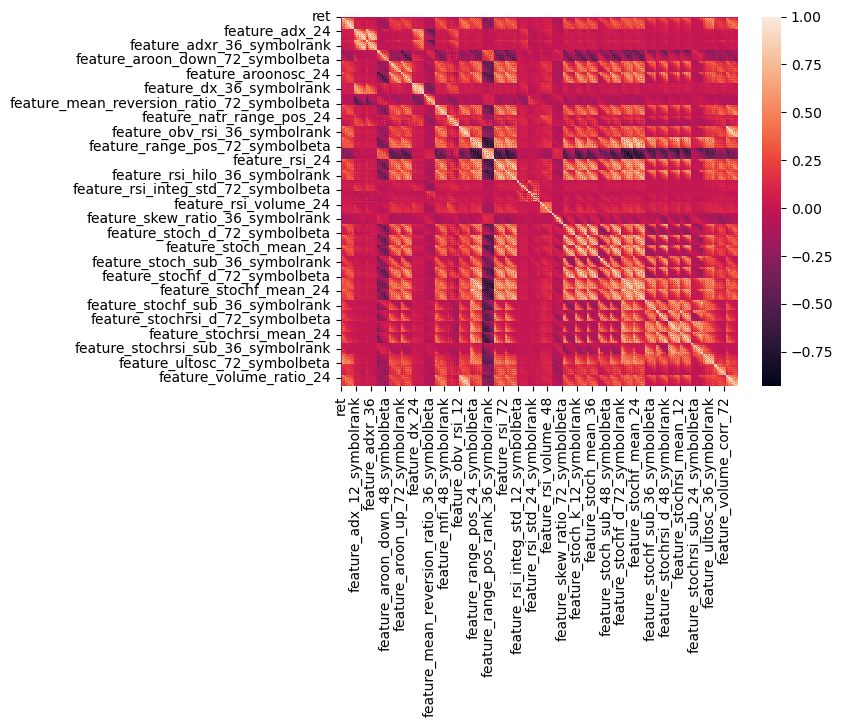

,ret,ret_rank,feature_rsi_24_symbolrank
feature_volume_corr_36_symbolbeta,0.013170,-0.027258,0.304875
feature_volume_corr_72_symbolbeta,0.021214,-0.026399,0.207916
feature_volume_corr_48_symbolbeta,0.014620,-0.026299,0.270326
feature_range_pos_rank_72_symbolbeta,-0.035461,-0.025175,-0.615273
feature_volume_corr_36_symbolrank,0.010613,-0.024782,0.258687
feature_volume_corr_24_symbolbeta,0.012260,-0.024139,0.333103
feature_volume_corr_48_symbolrank,0.012935,-0.023219,0.225742
feature_range_pos_rank_72_symbolrank,-0.035686,-0.022953,-0.675400
feature_volume_corr_24_symbolrank,0.010765,-0.021179,0.281769
feature_range_pos_rank_48_symbolrank,-0.033866,-0.021112,-0.694835


In [5]:
sns.heatmap(corr)
plt.show()

# corr['feature_rsi_24_abs'] = corr['feature_rsi_24'].abs()
# sns.heatmap(corr.sort_values('feature_rsi_24_abs')[['ret', 'ret_rank', 'feature_rsi_24']])
# plt.show()
# display(corr.sort_values('feature_rsi_24_abs')[['ret', 'ret_rank', 'feature_rsi_24']])
display(corr.sort_values('ret_rank')[['ret', 'ret_rank', 'feature_rsi_24_symbolrank']])

In [6]:
def validate_df2(df):
    df = df[['ret', 'ret_rank'] + get_feature_columns(df)]
    for col in df.columns:
        print(col, df[col].min(), df[col].max(), df[col].mean(), df[col].median())

validate_df2(df)

ret -0.6461836988109263 1.1613913875475612 0.0036794575963552184 0.0010796608180582146
ret_rank -0.5 0.5 -1.0904481398064098e-17 0.0
feature_ad_rsi_12 -1.0000000000000864 1.0000000000000144 0.05014509889366888 0.054289548491011516
feature_ad_rsi_12_symbolbeta -1.4119944353086926 1.3122030874161132 0.010056719238114587 0.009483040557732081
feature_ad_rsi_12_symbolrank -1.0 1.0 -2.227245771170727e-17 0.0
feature_ad_rsi_24 -1.0 1.0 0.0518204040136784 0.05318858199955756
feature_ad_rsi_24_symbolbeta -1.3272390997315544 1.1180445211658436 0.010614323903382876 0.009008412637415995
feature_ad_rsi_24_symbolrank -1.0 1.0 -2.1832766314079445e-17 0.0
feature_ad_rsi_36 -1.0 1.0 0.05219299349085294 0.05205433479952102
feature_ad_rsi_36_symbolbeta -1.3272390997315544 1.019009249044512 0.010782185187972365 0.009037445133048837
feature_ad_rsi_36_symbolrank -1.0 1.0 -2.1839952281762842e-17 0.0
feature_ad_rsi_48 -1.0 1.0 0.05245714686009543 0.05163148525237834
feature_ad_rsi_48_symbolbeta -1.32723909973

shape (247198, 512)
isfinite True
min -1.7567866390925237
max 1.7595836928489776


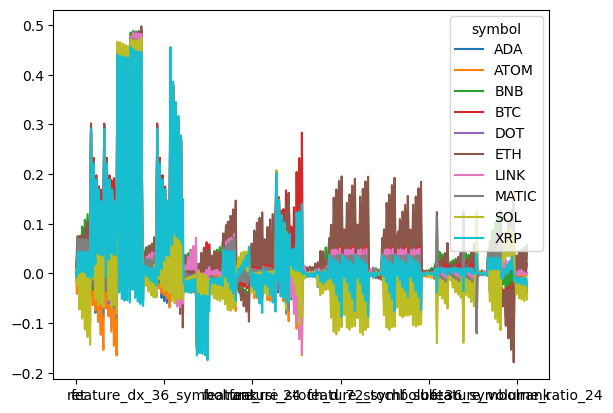

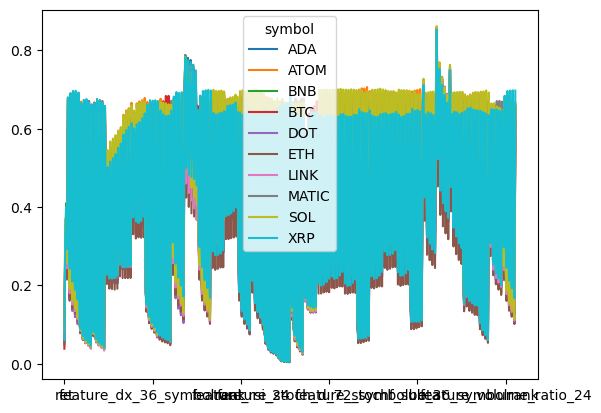

,mean_std,std_std
feature_rsi_std_72_symbolrank,0.140392,0.034137
feature_adxr_72_symbolrank,0.115031,0.018754
feature_rsi_std_48_symbolrank,0.113763,0.022063
feature_volume_corr_72_symbolrank,0.112199,0.017228
feature_adxr_48_symbolrank,0.111355,0.022398
feature_adxr_36_symbolrank,0.103716,0.023990
feature_adx_72_symbolrank,0.103341,0.018490
feature_rsi_std_36_symbolrank,0.099310,0.023361
feature_adx_48_symbolrank,0.097197,0.021060
feature_stoch_mean_72_symbolrank,0.096069,0.041825


,mean_std,std_std
feature_stochrsi_k_12_symbolbeta,0.007712,0.042840
feature_stoch_k_72_symbolrank,0.091397,0.042643
feature_stochf_d_72_symbolrank,0.091919,0.042343
feature_stoch_d_72_symbolrank,0.095516,0.042092
feature_stoch_d_48_symbolrank,0.088852,0.041923
feature_stoch_mean_48_symbolrank,0.088748,0.041847
feature_stoch_mean_72_symbolrank,0.096069,0.041825
feature_stoch_k_48_symbolrank,0.084263,0.041685
feature_stochf_d_48_symbolrank,0.084602,0.041614
feature_stoch_mean_36_symbolrank,0.084820,0.041498


shape (247198, 249)
isfinite True
min -1.5
max 1.3057292147350505


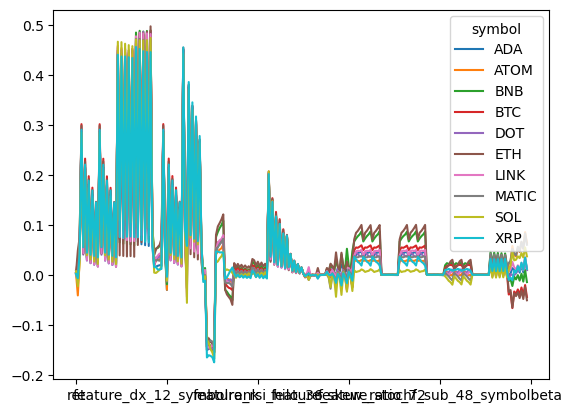

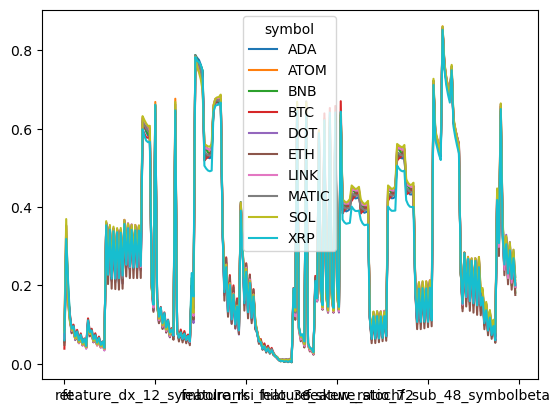

,mean_std,std_std
feature_volume_corr_12_symbolrank,0.044957,0.017908
feature_mean_reversion_ratio_12_symbolrank,0.039219,0.019229
feature_volume_corr_72_symbolbeta,0.038672,0.013564
feature_volume_corr_72,0.037220,0.012591
feature_volume_corr_48_symbolbeta,0.034493,0.013211
feature_volume_corr_48,0.033015,0.011654
feature_volume_corr_36_symbolbeta,0.031988,0.013444
feature_volume_corr_36,0.030553,0.011602
feature_dx_12_symbolrank,0.028917,0.019422
feature_stochf_d_72,0.028246,0.017022


,mean_std,std_std
ret_rank,0.027243,0.028995
feature_rsi_volume_36_symbolrank,0.006515,0.019941
feature_dx_12_symbolrank,0.028917,0.019422
feature_mfi_72_symbolbeta,0.007729,0.019338
feature_mean_reversion_ratio_12_symbolrank,0.039219,0.019229
feature_ultosc_12_symbolbeta,0.009177,0.019084
feature_mfi_72,0.008267,0.018776
feature_ad_rsi_72,0.017487,0.018676
feature_rsi_12_symbolbeta,0.007589,0.018520
feature_aroon_up_48_symbolbeta,0.013696,0.018391


shape (247198, 512)
isfinite True
min -1.7567866390925237
max 1.7595836928489776


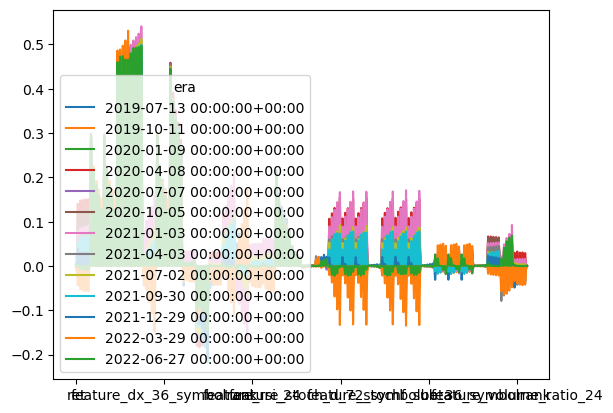

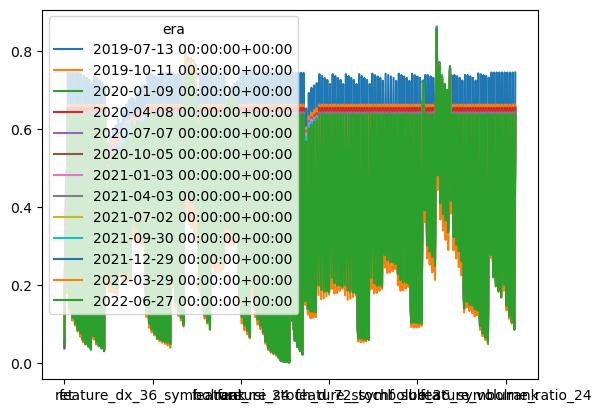

,mean_std,std_std
feature_range_pos_72,0.091176,0.028641
feature_range_pos_rank_72,0.090361,0.013060
feature_stoch_d_72,0.086102,0.029471
feature_stoch_mean_72,0.085736,0.029481
feature_stochf_d_72,0.085680,0.028950
feature_stochf_mean_72,0.085462,0.028607
feature_stoch_k_72,0.085431,0.029108
feature_stochf_k_72,0.085323,0.028726
feature_aroonosc_72,0.081860,0.017998
feature_range_pos_48,0.077791,0.025590


,mean_std,std_std
feature_ad_rsi_12_symbolbeta,0.009606,0.068711
feature_obv_rsi_12_symbolbeta,0.003781,0.063507
feature_volume_ratio_12_symbolbeta,0.003766,0.062562
feature_mfi_12_symbolbeta,0.004237,0.061918
feature_ad_rsi_24_symbolbeta,0.010272,0.061485
feature_obv_rsi_12,0.021659,0.058847
feature_natr_range_pos_12_symbolbeta,0.010539,0.058235
feature_obv_rsi_24_symbolbeta,0.003682,0.058087
feature_volume_ratio_12,0.021529,0.057814
feature_volume_ratio_24_symbolbeta,0.003665,0.057153


shape (247198, 178)
isfinite True
min -1.5
max 1.1613913875475612


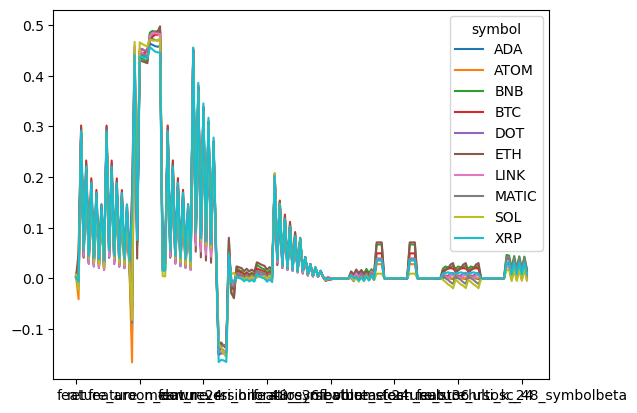

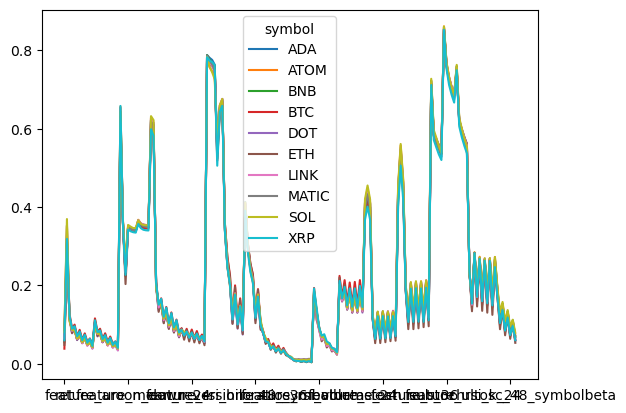

,mean_std,std_std
feature_adxr_72_symbolrank,0.115031,0.018754
ret_rank,0.027243,0.028995
feature_aroon_down_12_symbolbeta,0.019150,0.015306
feature_stoch_k_12,0.017963,0.016306
feature_stoch_mean_12,0.017960,0.015571
feature_stoch_d_12,0.017957,0.015585
feature_stochf_d_12,0.017938,0.016291
feature_stochf_mean_12,0.017936,0.016294
feature_stochf_k_12,0.017933,0.017741
feature_range_pos_12,0.016132,0.017833


,mean_std,std_std
ret_rank,0.027243,0.028995
feature_adxr_72_symbolrank,0.115031,0.018754
feature_range_pos_12,0.016132,0.017833
feature_stochf_k_12,0.017933,0.017741
feature_stoch_k_12,0.017963,0.016306
feature_stochf_mean_12,0.017936,0.016294
feature_stochf_d_12,0.017938,0.016291
feature_stoch_d_12,0.017957,0.015585
feature_stoch_mean_12,0.017960,0.015571
feature_stochrsi_sub_72_symbolbeta,0.000068,0.015436


In [7]:
def validate_df(df, g='symbol'):
    df = df[['ret', 'ret_rank'] + get_feature_columns(df)].copy()
    print('shape', df.shape)
    print('isfinite {}'.format(np.all(np.isfinite(df.values))))
    print('min {}'.format(np.min(df.values)))
    print('max {}'.format(np.max(df.values)))

    df['era'] = df.index.get_level_values('timestamp').floor('90D')

    # display(df.groupby(g).describe())

    df.groupby(g).mean().transpose().plot()
    plt.show()
    df.groupby(g).std().transpose().plot()
    plt.show()

    display(pd.concat([
        df.groupby(g).mean().std().rename('mean_std'),
        df.groupby(g).std().std().rename('std_std'),
    ], axis=1).sort_values('mean_std', ascending=False).iloc[:30])

    display(pd.concat([
        df.groupby(g).mean().std().rename('mean_std'),
        df.groupby(g).std().std().rename('std_std'),
    ], axis=1).sort_values('std_std', ascending=False).iloc[:30])

def preprocess_df(df, g='symbol', mean_th=0.05, std_th=0.02):
    df2 = df[get_feature_columns(df)].copy()

    df2['era'] = df2.index.get_level_values('timestamp').floor('90D')

    mean_std = df2.groupby(g).mean().std()
    std_std = df2.groupby(g).std().std()
    std = df2.std()

    excluded_feature = mean_std[mean_std > mean_th].index.tolist() + std_std[std_std > std_th].index.tolist() + std[std == 0.0].index.tolist()

    df = df.loc[:, ~df.columns.isin(excluded_feature)]

    return df

validate_df(df)
validate_df(preprocess_df(df))
validate_df(df, g='era')
validate_df(preprocess_df(df, g='era'))

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
import lightgbm as lgb
import numpy as np
import pandas as pd

class CorrFeatureRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.99, method='pearson'):
        self.threshold = threshold
        self.method = method

    def fit(self, X, y=None):
        X = self._validate_data(X)
        
        if method == 'pearson':
            
        elif method == 'spearman':
            
        else:
            raise Exception('unknown method {}'.format(method))

        model = lgb.LGBMRegressor(n_jobs=-1, random_state=1)

        model.fit(X, np.arange(X.shape[0]))
        importances = model.feature_importances_

        if self.remove_count:
            remove_count = self.remove_count
        else:
            remove_count = int(self.remove_ratio * X.shape[1])

        features = list(range(X.shape[1]))
        feature_imp = pd.DataFrame(zip(importances, features), columns=['value', 'feature'])
        feature_imp = feature_imp.sort_values('value')

        for i in range(X.shape[1] - remove_count, X.shape[1]):
            features.remove(int(feature_imp['feature'].iloc[i]))

        self.selected_features_ = np.array(features)

        return self

    def transform(self, X, y=None):
        X = self._validate_data(X)

        return X[:, self.selected_features_].copy()

    def inverse_transform(self, X, y=None):
        raise Exception('inverse_transform not implemented')


PearsonRResult(statistic=0.06626715004200082, pvalue=1.150082434199678e-133)
SpearmanrResult(correlation=0.0541037186268348, pvalue=1.0957947613173145e-89)
PearsonRResult(statistic=0.06533857898273263, pvalue=5.404544814095717e-130)
SpearmanrResult(correlation=0.06004150590907031, pvalue=4.837480709696341e-110)
PearsonRResult(statistic=0.07891434870414196, pvalue=7.082977112019485e-189)
SpearmanrResult(correlation=0.06418554969787992, pvalue=1.6592769898257058e-125)


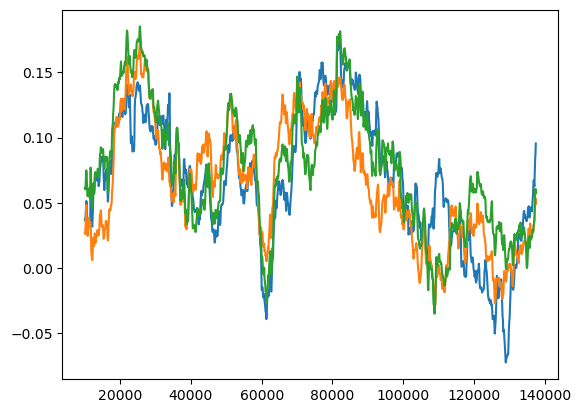

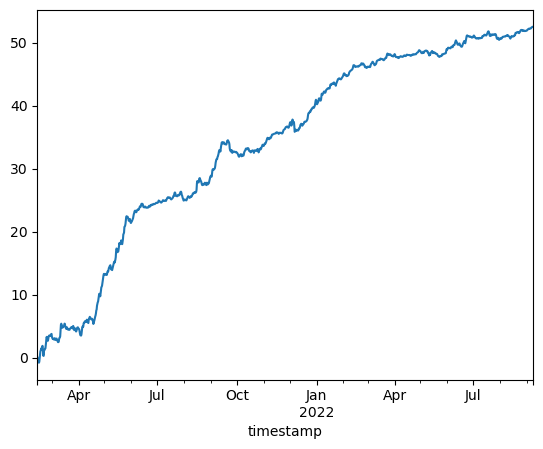

PearsonRResult(statistic=0.04806520743172109, pvalue=3.684151997039678e-71)
SpearmanrResult(correlation=0.029432842934908013, pvalue=9.430504856246302e-28)
PearsonRResult(statistic=0.07243456849582587, pvalue=2.2299690361904294e-159)
SpearmanrResult(correlation=0.05782872910476974, pvalue=3.298018295074258e-102)
PearsonRResult(statistic=0.06911604897057844, pvalue=2.9478676837763698e-145)
SpearmanrResult(correlation=0.04980457708618725, pvalue=2.8462483164055657e-76)


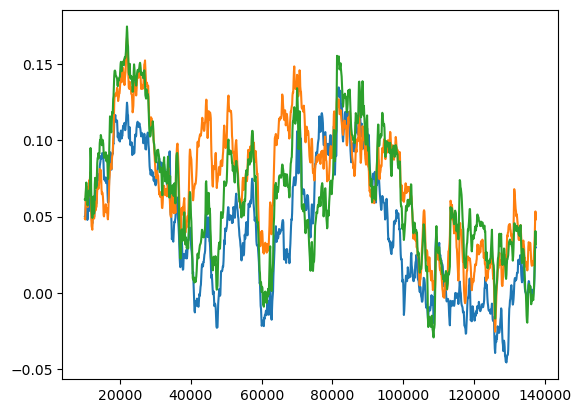

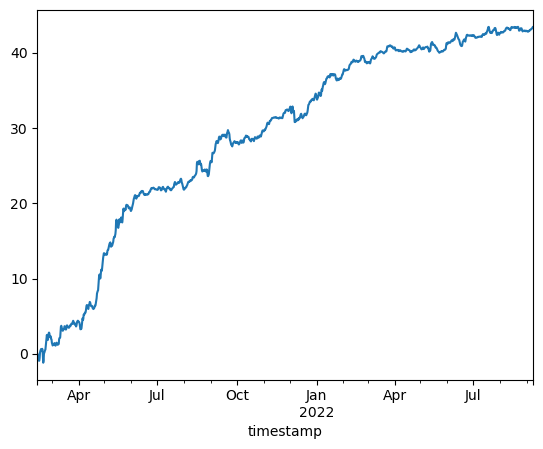

In [187]:
import lightgbm as lgb
from scipy.stats import pearsonr, spearmanr
import random
import gc
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import FeatureAgglomeration
import xgboost as xgb
from sklearn.ensemble import HistGradientBoostingRegressor, BaggingRegressor
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, AveragePooling1D, Conv1D, Reshape, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
from scikeras.wrappers import KerasRegressor
from functools import partial

gc.collect()

def build_keras_model(input_size):
    inputs = Input(shape=(input_size,))
    x = inputs
    
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='linear')(x)
    
    # x = Dense(64, use_bias=True)(x)
    # x = Reshape((8, 8))(x)
    # x = Conv1D(filters=8, kernel_size=5, activation='relu', use_bias=True, padding='SAME')(x)
    # x = Dropout(0.5)(x)
    # x = Conv1D(filters=8, kernel_size=5, activation='relu', use_bias=True, padding='SAME')(x)
    # x = Dropout(0.5)(x)
    # x = AveragePooling1D(pool_size=4, strides=2)(x)
    # x = Flatten()(x)
    # x = Dense(1, activation='linear')(x)
    
    model = Model(inputs=inputs, outputs=x)
    # opt = 'sgd'
    opt = Nadam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
    model.compile(optimizer=opt,
                  loss='mean_squared_error',
                  metrics=[])
    return model

def process(df, y_type='rank', model_type='lgbm', random_state=1, pos_type='beta', loss='regression', colsample_bytree=1.0,
           feature_union=False, y_transform=False):
    df = df.copy()
    # df = preprocess_corr(df, th=0.99)
    # df = preprocess_df(df, g='era', mean_th=0.1, std_th=0.05)
    # df = preprocess_df(df, g='symbol', mean_th=0.05, std_th=0.02)

    if model_type == 'lgbm':
        model = lgb.LGBMRegressor(
            # n_estimators=1000,
            # learning_rate=0.01,
            n_estimators=100,
            learning_rate=0.1,
            colsample_bytree=colsample_bytree,
            # colsample_bytree=0.9,
            # boosting_type='rf',
            # subsample=0.9,
            # subsample_freq=10,
            # extra_trees=True,
            objective=loss,
            random_state=random_state,
            n_jobs=-1,
            importance_type="gain",
        )
    elif model_type == 'lgbm_et':
        model = lgb.LGBMRegressor(
            # n_estimators=1000,
            # learning_rate=0.01,
            n_estimators=100,
            learning_rate=0.1,
            colsample_bytree=colsample_bytree,
            # colsample_bytree=0.9,
            # boosting_type='rf',
            # subsample=0.9,
            # subsample_freq=10,
            objective=loss,
            extra_trees=True,
            random_state=random_state,
            n_jobs=-1,
            importance_type="gain",
        )
    elif model_type == 'lgbm_clf':
        model = lgb.LGBMClassifier(
            # n_estimators=1000,
            # learning_rate=0.01,
            n_estimators=100,
            learning_rate=0.1,
            colsample_bytree=colsample_bytree,
            # colsample_bytree=0.9,
            # boosting_type='rf',
            # subsample=0.9,
            # subsample_freq=10,
            # extra_trees=True,
            random_state=random_state,
            n_jobs=-1,
            importance_type="gain",
        )
    elif model_type == 'xgb':
        model = xgb.XGBRegressor(
            # n_estimators=1000,
            # learning_rate=0.01,
            n_estimators=100,
            learning_rate=0.1,
            colsample_bytree=colsample_bytree,
            # boosting_type='rf',
            # subsample=0.1,
            # subsample_freq=3,
            # extra_trees=True,
            random_state=random_state,
            n_jobs=-1,
        )
    elif model_type == 'histgb':
        model = HistGradientBoostingRegressor(
            max_iter=100,
            learning_rate=0.01,
            random_state=random_state
        )
    
    model = BaggingRegressor(model, random_state=random_state)
    
    # model = lgb.LGBMRanker(
    #     n_estimators=1000,
    #     learning_rate=0.01,
    #     colsample_bytree=0.03,
    #     objective="lambdarank",
    #     extra_trees=True,
    #     # label_gain=np.arange(100),
    #     # lambdarank_truncation_level=max_labels,
    #     # max_depth=5,
    #     # colsample_bytree=0.5,
    #     # num_leaves=2**6-1,
    #     n_jobs=-1
    # )
    # model = Ridge(alpha=1e3)
    
    if feature_union:
        union = FeatureUnion([
            ("pt", 'passthrough'),
            ("pca", PCA(n_components=32)),
            ("svd", TruncatedSVD(n_components=32)),
            ("agg", FeatureAgglomeration(n_clusters=32)),
        ])
        model = Pipeline([
            # ('feat_agglo', FeatureAgglomeration(n_clusters=64)),
            ('union', union),
            ('model', model)
        ])
        
    if y_transform:
        model = TransformedTargetRegressor(
            regressor=model,
            transformer=QuantileTransformer(random_state=1)
        )

    # display(df.iloc[:20])

    features = get_feature_columns(df)
    # features = [x for x in features if 'feature_rsi' in x]

    dfs = [
        df,
        # df.loc[:, ~df.columns.isin(features)],
    ]
    for col in features:
        col2 = random.choice(features)
        col3 = random.choice(features)
        dfs += [
            # (df[col] ** 2).rename(col + '_sqr'),
            # df[col].abs().rename(col + '_abs'),
            # (df[col].abs() - 0.25).abs().rename(col + '_abs2'),
            # (df[col] * df[col2]).rename(col + '_mul_' + col2),
            # (df[col] / (0.6 + df[col2])).rename(col + '_div_' + col2),
            # (df[col] * df[col2] * df[col3]).rename(col + '_mul_' + col2 + '_mul_' + col3),
        ]
    df = pd.concat(dfs, axis=1)
    df = df.dropna()
    features = get_feature_columns(df)

    group = df.groupby('timestamp')['cl'].count()
    # test_min_idx = int(df.shape[0] * 0.5)
    group_test_min_idx = int(group.shape[0] * 0.5)
    test_min_idx = np.sum(group.iloc[:group_test_min_idx])
    
    # df['ret_rank_int'] = df.groupby('timestamp')['ret'].rank(method='min')
    # model.fit(df[features].iloc[:test_min_idx], df['ret_rank_int'].iloc[:test_min_idx], group=group.iloc[:group_test_min_idx])
    
#     model = KerasRegressor(
#         model=partial(build_keras_model, len(features)), 
#         random_state=1,
#         epochs=1,
#     )
    
    if y_type == 'rank':
        model.fit(df[features].iloc[:test_min_idx], df['ret_rank'].iloc[:test_min_idx])
    elif y_type == 'rank_weight':
        model.fit(df[features].iloc[:test_min_idx], np.sign(df['ret_rank'].iloc[:test_min_idx]), sample_weight=np.abs(df['ret_rank'].iloc[:test_min_idx]))
    elif y_type == 'rank_beta_weight':
        model.fit(df[features].iloc[:test_min_idx], df['ret_rank'].iloc[:test_min_idx], sample_weight=np.abs(df['ret_beta'].iloc[:test_min_idx]))
    elif y_type == 'rank_beta_mean_weight':
        model.fit(df[features].iloc[:test_min_idx], df['ret_rank'].iloc[:test_min_idx], sample_weight=np.abs(df['ret_beta']).groupby('timestamp').transform('mean').iloc[:test_min_idx])
    elif y_type == 'beta':
        model.fit(df[features].iloc[:test_min_idx], np.sign(df['ret_beta'].iloc[:test_min_idx]), sample_weight=np.abs(df['ret_beta'].iloc[:test_min_idx]))
    elif y_type == 'beta_simple':
        model.fit(df[features].iloc[:test_min_idx], df['ret_beta'].iloc[:test_min_idx])
        
    # model.fit(df[features].iloc[:test_min_idx], np.sign(df['ret_rank'].iloc[:test_min_idx]), sample_weight=np.abs(df['ret_rank'].iloc[:test_min_idx]))
    # model.fit(df[features].iloc[:test_min_idx], df['ret_beta'].iloc[:test_min_idx])
    # # model.fit(df[features].iloc[:test_min_idx], df['ret'].iloc[:test_min_idx])

    df.loc[df.index[test_min_idx:], 'y_pred'] = model.predict(df[features].iloc[test_min_idx:])
    df2 = df.iloc[test_min_idx:].reset_index()
    print(pearsonr(df2['ret'], df2['y_pred']))
    print(spearmanr(df2['ret'], df2['y_pred']))
    print(pearsonr(df2['ret_rank'], df2['y_pred']))
    print(spearmanr(df2['ret_rank'], df2['y_pred']))
    print(pearsonr(df2['ret_beta'], df2['y_pred']))
    print(spearmanr(df2['ret_beta'], df2['y_pred']))
    df2['ret'].rolling(10000).corr(df2['y_pred']).dropna().iloc[::100].plot()
    df2['ret_rank'].rolling(10000).corr(df2['y_pred']).dropna().iloc[::100].plot()
    df2['ret_beta'].rolling(10000).corr(df2['y_pred']).dropna().iloc[::100].plot()
    plt.show()
    
    df2['position'] = df2['y_pred']
    
    if pos_type == 'rank':
        df2['position'] = unbiased_rank(df2.groupby('timestamp')['y_pred']) - 0.5
    elif pos_type == 'beta':
        df2['position_beta'] = df2['position'] * df2['beta']
        df2['position'] -= df2.groupby('timestamp')['position_beta'].transform('mean')
    elif pos_type == 'rank_and_beta':
        df2['position_beta'] = df2['position'] * df2['beta']
        df2['position'] -= df2.groupby('timestamp')['position_beta'].transform('mean')
        normalize_position(df2)
        df3 = df2.copy()
        df3['position'] = unbiased_rank(df3.groupby('timestamp')['y_pred']) - 0.5
        normalize_position(df3)
        df2['position'] = (df2['position'] + df3['position']) / 2
        
    normalize_position(df2)
    
    df2 = df2.set_index('timestamp')
    (df2['ret'] * df2['position']).dropna().cumsum().iloc[::100].plot()
    plt.show()

    # importance = pd.DataFrame(model.feature_importances_, index=features, columns=['imp'])
    # display(importance.sort_values('imp', ascending=False))
    
    return df2

# df2 = process(df, y_type='rank', model_type='lgbm', random_state=1)
# df3 = process(df, y_type='rank', model_type='lgbm', random_state=2)

# df2 = process(df, y_type='rank', model_type='lgbm')
# df3 = process(df, y_type='rank', model_type='xgb')

# df2 = process(df, y_type='rank', model_type='lgbm')
# df3 = process(df, y_type='rank', model_type='histgb')

# df2 = process(df, y_type='rank', pos_type='beta')
# df3 = process(df, y_type='rank', pos_type='rank')

# df2 = process(df, y_type='beta', pos_type='beta')
# df3 = process(df, y_type='beta', pos_type='rank')

# df2 = process(df, y_type='rank', pos_type='beta')
# df3 = process(df, y_type='rank', pos_type='rank_and_beta')

# df2 = process(df, y_type='rank')
# df3 = process(df, y_type='beta')

# df2 = process(df, y_type='rank')
# df3 = process(df, y_type='rank_weight')

# df2 = process(df, y_type='rank')
# df3 = process(df, y_type='rank_beta_weight')

# df2 = process(df, y_type='beta')
# df3 = process(df, y_type='rank_beta_weight')

df2 = process(df, y_type='beta')
df3 = process(df, y_type='rank_beta_mean_weight')

# df2 = process(df, y_type='beta_simple', y_transform=False)
# df3 = process(df, y_type='beta_simple', y_transform=True)

# df2 = process(df, y_type='rank', pos_type='rank')
# df3 = process(df, y_type='beta', pos_type='beta')

# df2 = process(df, y_type='beta', model_type='lgbm')
# df3 = process(df, y_type='beta', model_type='lgbm_clf')

# df2 = process(df, y_type='beta', model_type='lgbm')
# df3 = process(df, y_type='beta', model_type='lgbm_et')

# df2 = process(df, y_type='beta', model_type='lgbm')
# df3 = process(df, y_type='beta_simple', model_type='lgbm')

# df2 = process(df, y_type='rank', model_type='lgbm', loss='regression')
# df3 = process(df, y_type='rank', model_type='lgbm', loss='regression_l1')

# df2 = process(df, y_type='rank', model_type='lgbm', colsample_bytree=1.0)
# df3 = process(df, y_type='rank', model_type='lgbm', colsample_bytree=0.03)

# df2 = process(df, y_type='rank', model_type='lgbm', feature_union=False)
# df3 = process(df, y_type='rank', model_type='lgbm', feature_union=True)

In [188]:
df2['position_df3'] = df3['position']

for symbol, df_symbol in df2.groupby('symbol'):
    print(symbol, df_symbol['position'].corr(df_symbol['position_df3']))

df2['position_ret'] = df2['position'] * df2['ret']
df2['position_df3_ret'] = df2['position_df3'] * df2['ret']

def sharpe(x):
    return x.mean() / x.std()
    
print(df2.groupby('timestamp')['position_ret'].sum().corr(df2.groupby('timestamp')['position_df3_ret'].sum()))  

print(sharpe(df2.groupby('timestamp')['position_ret'].sum()))
print(sharpe(df2.groupby('timestamp')['position_df3_ret'].sum()))
print(sharpe(df2.groupby('timestamp')['position_ret'].sum() + df2.groupby('timestamp')['position_df3_ret'].sum()))

df2['position_sum'] = df2['y_pred'] + df3['y_pred']
df2['position_sum_rank'] = unbiased_rank(df2.groupby('timestamp')['position_sum']) - 0.5
df2['position_sum_beta'] = df2['position_sum'] * df2['beta']
df2['position_sum'] -= df2.groupby('timestamp')['position_sum_beta'].transform('mean')

df2["position_sum_rank_abs"] = df2["position_sum_rank"].abs()
df2["position_sum_rank"] /= 1e-37 + df2.groupby("timestamp")["position_sum_rank_abs"].transform("sum")
df2["position_sum_abs"] = df2["position_sum"].abs()
df2["position_sum"] /= 1e-37 + df2.groupby("timestamp")["position_sum_abs"].transform("sum")

df2['position_sum_rank_ret'] = df2['position_sum_rank'] * df2['ret']
df2['position_sum_ret'] = df2['position_sum'] * df2['ret']
print(sharpe(df2.groupby('timestamp')['position_sum_rank_ret'].sum()))
print(sharpe(df2.groupby('timestamp')['position_sum_ret'].sum()))

ADA 0.8118675240441493
ATOM 0.8288264769277642
BNB 0.8082098313649784
BTC 0.7912322781055067
DOT 0.7889179708226027
ETH 0.7987333475147621
LINK 0.8134846499918761
MATIC 0.8201641119355854
SOL 0.8284294651712502
XRP 0.7767853709668388
0.8365977628794867
0.2021653959903503
0.16182470726991355
0.189589037633962
0.20666716530459806
0.1980720222298504


(512, 512)


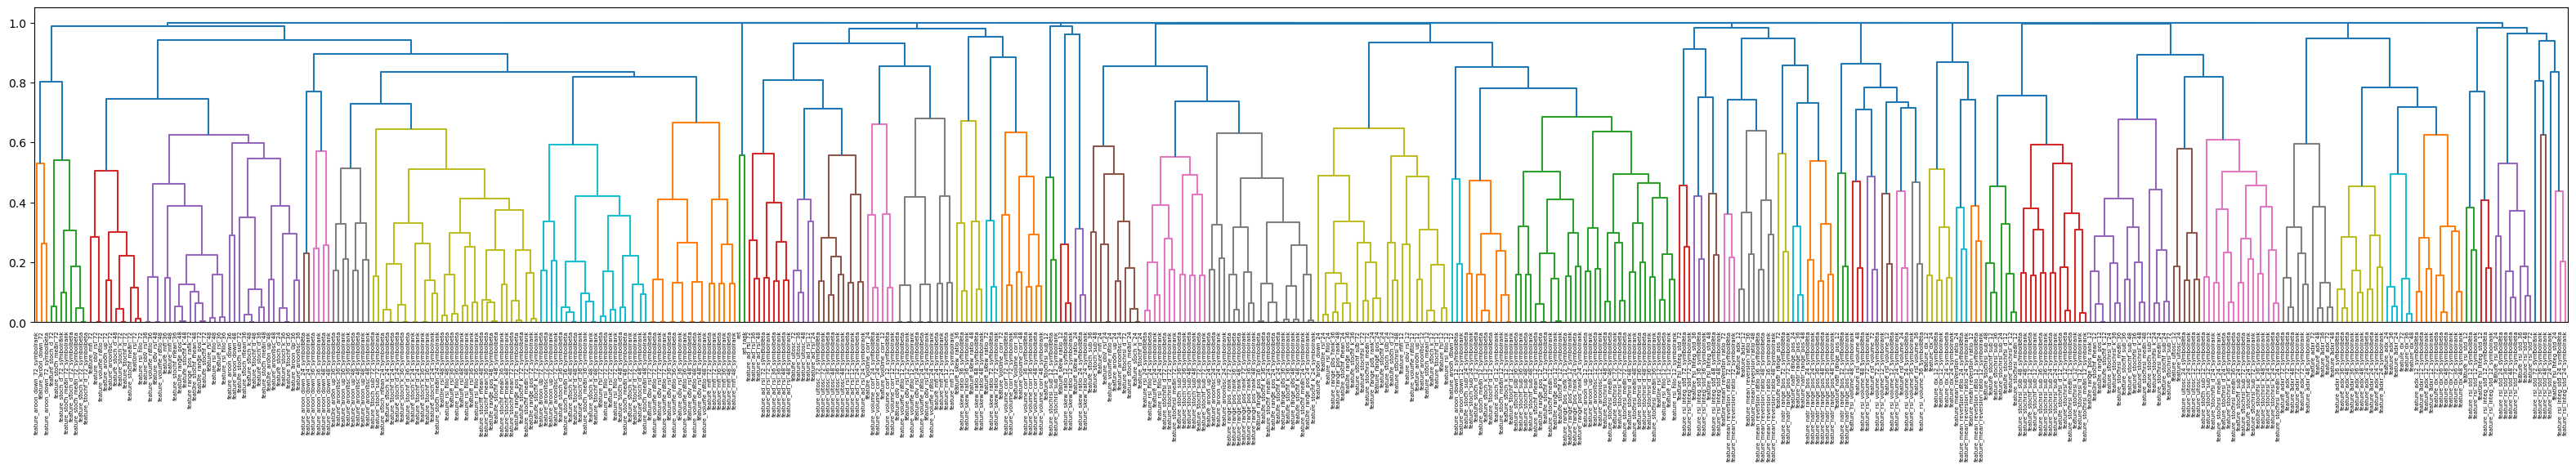

In [10]:
# https://www.kaggle.com/code/sgalella/correlation-heatmaps-with-hierarchical-clustering

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

plt.figure(figsize=(40,5))
dissimilarity = 1 - abs(corr)
dissimilarity = dissimilarity.dropna(axis=0, how='all').dropna(axis=1, how='all')
print(dissimilarity.shape)
# display(dissimilarity)
# display(dissimilarity.values - dissimilarity.values.T)
Z = linkage(squareform(dissimilarity, checks=False), 'complete')

dendrogram(Z, labels=dissimilarity.columns, orientation='top',
           leaf_rotation=90)
plt.show()